# manueverMotifs full analysis
## Normal trip in secondary road - Lateral acceleration

### Maria Inês Silva
### 05/02/2019

***

**Contents**

1. [Data and library imports](#section1)
2. [Motif extraction](#section2)
3. [Motif prunning](#section3)
4. [Motif clustering](#section4)
5. [Add-hoc exploration](#section5)

***

<a id='section1'></a>
## 1. Data and library imports

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
from sklearn.cluster import DBSCAN
from extendedMD.emd import find_motifs_from_emd
from extendedMD.viz import create_motif_table
from extendedMD.pruning import prune_motifs_with_mdl

# local code
import sys
import os
sys.path.insert(0, os.path.abspath('../scripts'))
import uah_utils
import motif_utils
import lat_viz

In [2]:
cwd = os.getcwd()
data_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data-uah/D6'))

driver_df = uah_utils.get_full_point_uah_data(data_folder)
trip_df = driver_df[driver_df['trip_id']=='20151221112434']
ts = trip_df['ay'].values
events_ts = trip_df['event_type'].values

**Remove!**

In [3]:
output_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data-motifs'))
motif_file_name = 'motif_lat_acc_secondary_trip.p'
dist_file_name = 'dist_lat_acc_secondary_trip.npy'

motif_dic_list = pickle.load(open(os.path.join(output_folder, motif_file_name), 'rb'))
center_dist_mat = np.load(os.path.join(output_folder, dist_file_name))

<a id='section2'></a>
## 2. Motif extraction

In [4]:
R = 0.1
win_size = 10
paa_size = 2
alphabet_size = 5
adaptive_break_points = False

In [ ]:
start_time = time.time()
motif_dic_list, ts_1d = find_motifs_from_emd(ts, R, win_size, paa_size, alphabet_size, adaptive_break_points)
print("ExtendedMD algorithm run in {} minutes".format(round((time.time() - start_time)/60, 2)))

In [5]:
len(motif_dic_list)

2524

<a id='section3'></a>
## 3. Motif prunning

In [6]:
pruned_motif_dic_list = prune_motifs_with_mdl(ts, motif_dic_list, R)

pruned_motif_df = create_motif_table(pruned_motif_dic_list)
pruned_motif_df

,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,[cc],1,196,34835.80,0.05
1,"[bb, bc, bd, be, ce, de, ee]",7,4,73825.36,0.06


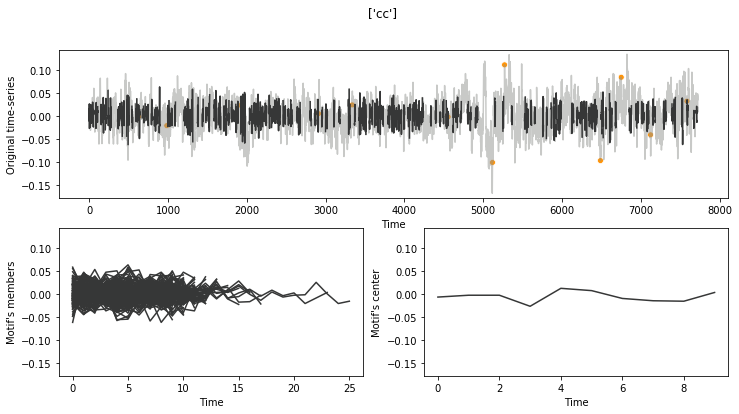

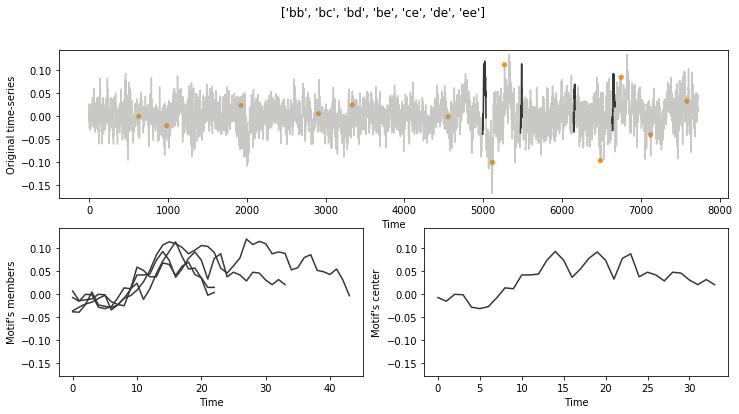

In [7]:
lat_viz.plot_k_lat_motifs(len(pruned_motif_df), ts, events_ts, pruned_motif_dic_list)

<a id='section4'></a>
## 4. Motif clustering

In [ ]:
center_ts_list = []
for motif_dic in motif_dic_list:
    motif_center_ts = [ts[i] for i in motif_dic['center_ts_pointers']]
    center_ts_list.append(motif_center_ts)
center_dist_mat = motif_utils.compute_dtw_distance_matrix(center_ts_list, parallel=True)

In [8]:
dbscan_model = DBSCAN(eps=R/2, min_samples=20, metric='precomputed').fit(center_dist_mat)
cluster_labels = dbscan_model.labels_
set(cluster_labels)

{-1, 0}

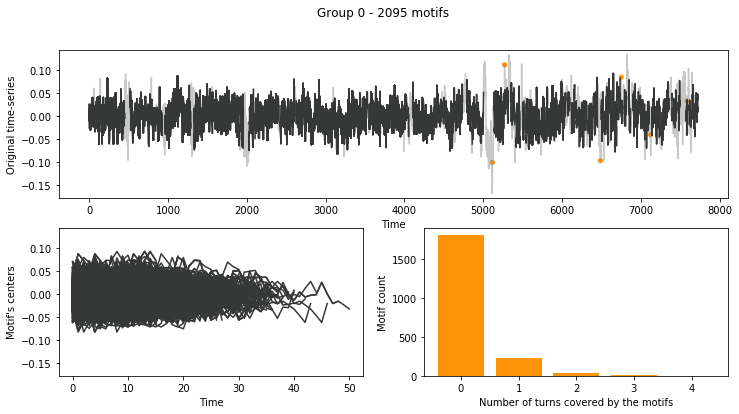

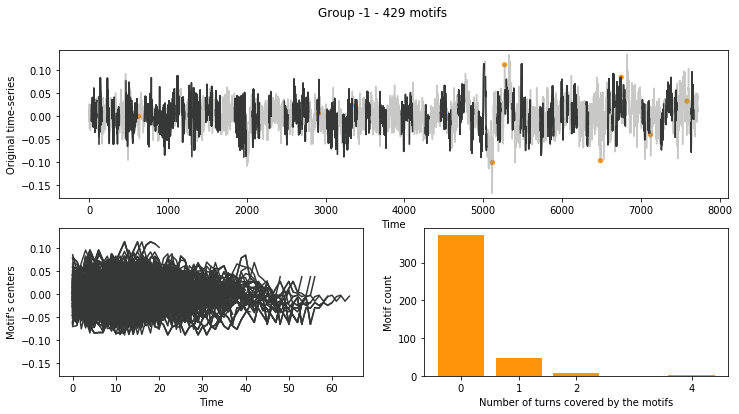

In [9]:
lat_viz.plot_lat_motif_groups(ts, events_ts, motif_dic_list, cluster_labels)

<a id='section5'></a>
## 5. Add-hoc exploration

In [10]:
mean_dist_list = [np.mean(vec) for vec in center_dist_mat]

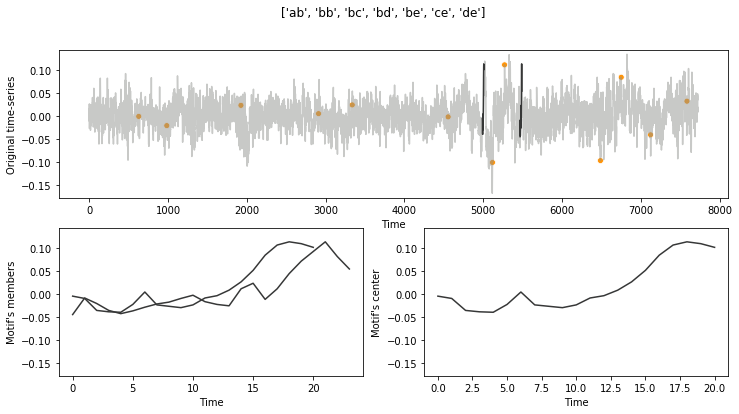

In [11]:
import matplotlib.pyplot as plt
motif_dic = motif_dic_list[np.argmax(mean_dist_list)]
lat_viz.plot_single_lat_motif(ts, events_ts, motif_dic)
plt.show()

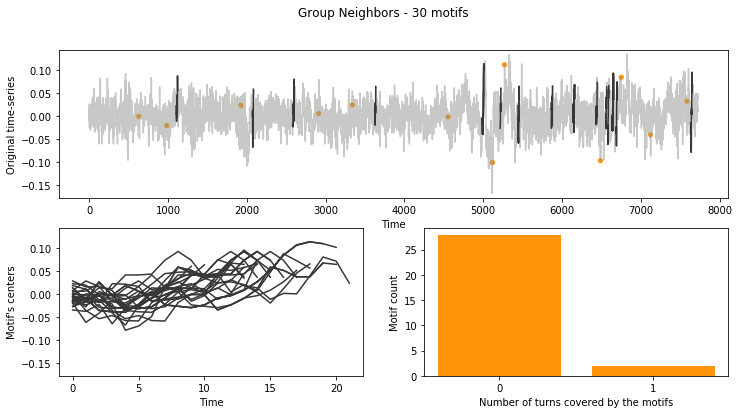

In [12]:
motif_index = motif_utils.return_motif_index_with_pattern(motif_dic_list, motif_dic['pattern'])
motif_neighbors_dic_list = motif_utils.get_motif_k_neighbors(motif_dic_list, motif_index, center_dist_mat, 30)
lat_viz.plot_single_lat_motif_group(ts, events_ts, motif_neighbors_dic_list, 'Neighbors')
plt.show()

In [13]:
create_motif_table(motif_neighbors_dic_list)

,pattern,pattern_len,n_members,mdl_cost,mean_dist
0,"[ab, bb, bc, bd, be, ce, de]",7,2,77467.51,0.04
1,"[ab, bb, bc, bd, be, ce]",6,2,77479.90,0.03
2,"[ab, bb, bc, bd, be]",5,2,77507.36,0.04
3,"[bb, bc, bd, be]",4,5,69349.01,0.05
4,"[bc, bd, be]",3,5,69393.07,0.04
5,"[bb, bc, bd, be, ce]",5,4,74120.68,0.04
6,"[bc, bd, be, ce]",4,4,74157.33,0.03
7,"[bd, be, ce, de]",4,8,67800.93,0.06
8,"[bb, bc, bd, be, ce, de]",6,5,69271.04,0.05
9,"[bc, bd, be, ce, de]",5,5,69312.55,0.05
